# Время раскрасить попугаев!
### Задание по кластеризации

Импортируем необходимые библиотеки:

In [1]:
from skimage.io import imread, imsave
from skimage import img_as_float
from sklearn.cluster import KMeans
import pandas as pd
import numpy as np
from math import log10
from IPython.display import Image

Загрузим картинку с попугаями:

In [5]:
img = imread('/Users/anastasia/Applications/LW-Python/parrots.jpg') # вставить сюда путь к картинке
# нормализуем значения цветов пикселей к единице
img = img_as_float(img) 

# метод shape возвращает кортеж из ширины, высоты и количества цветов изображения
img.shape

(474, 713, 3)

Создайте переменные w и h, в которые запишите ширину и высоту изображения.

In [7]:
w, h = img.shape[:-1]
# Преобразуем изображение в одномерный массив.
fimg = img.reshape(w*h, -1)
print(w,h)

474 713


Качество изображений часто определяется метрикой PSNR (https://ru.wikipedia.org/wiki/%D0%9F%D0%B8%D0%BA%D0%BE%D0%B2%D0%BE%D0%B5_%D0%BE%D1%82%D0%BD%D0%BE%D1%88%D0%B5%D0%BD%D0%B8%D0%B5_%D1%81%D0%B8%D0%B3%D0%BD%D0%B0%D0%BB%D0%B0_%D0%BA_%D1%88%D1%83%D0%BC%D1%83). Реализуем ее:

In [8]:
# в эту функцию нам нужно будет передать обычное изображение и изображение с усредненными цветами
def psnr(img, mean_image):
    # посчитайте среднеквадратичную ошибку этих изображений
    mse = np.mean((img - mean_image)**2)
    # логарифмируем
    return 10 * log10(1. / mse)

Создадим матрицу с признаками объектов, в которую будем потом записывать номер кластера для каждого пикселя.

In [11]:
X = pd.DataFrame(data=fimg, columns=('R', 'G', 'B'))
X.head()

,R,G,B
0,0.015686,0.494118,0.019608
1,0.007843,0.494118,0.007843
2,0.007843,0.494118,0.007843
3,0.007843,0.494118,0.007843
4,0.007843,0.501961,0.011765


Кластеризатор k средних реализован в классе KMeans. Создайте объект этого кластеризатора с параметрами:
init='k-means++', random_state=вариант и каким-нибудь количеством классов n. Рекомендую также выставить параметр n_jobs=-1, чтобы кластеризация прошла быстрее.

In [10]:
from sklearn.cluster import KMeans
import numpy as np
kmeans =  KMeans(n_clusters=2, init='k-means++', n_init=10, random_state=3, n_jobs=-1)

Запишите результаты кластеризации (fit_predict) в новый столбец 'cluster' в таблице с данными X.

In [12]:
X['cluster'] = kmeans.fit_predict(X)
X.head()

,R,G,B,cluster
0,0.015686,0.494118,0.019608,1
1,0.007843,0.494118,0.007843,1
2,0.007843,0.494118,0.007843,1
3,0.007843,0.494118,0.007843,1
4,0.007843,0.501961,0.011765,1


Приготовим функцию, которая будет принимать в себя набор цветов для кластеров, а возвращать уже раскрашенное этими цветами изображение:

In [13]:
set_new_colors = lambda a: np.reshape(list(map(lambda c: a[c], X['cluster'])), (w, h, -1))
# использование: new_img = set_new_colors(colors), образец изображения уже "вшит" внутрь функции

Создайте с помощью приготовленной функции изображения, заполненные средними и медианными цветами кластеров:

In [14]:
mean_colors = X.groupby('cluster').mean().values
median_colors = X.groupby('cluster').median().values
mean_img = set_new_colors(mean_colors)
median_img = set_new_colors(median_colors)

Посмотрим на новые картинки. Усредненные цвета:

/anaconda3/lib/python3.6/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


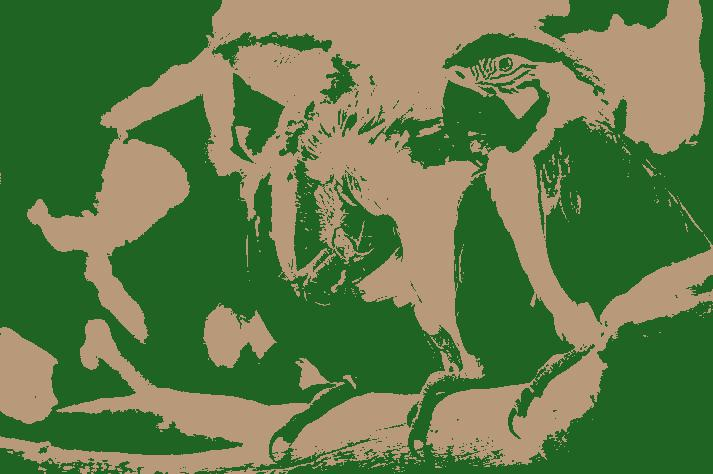

In [15]:
imsave('mean.jpg', mean_img)
Image(filename='mean.jpg')

/anaconda3/lib/python3.6/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


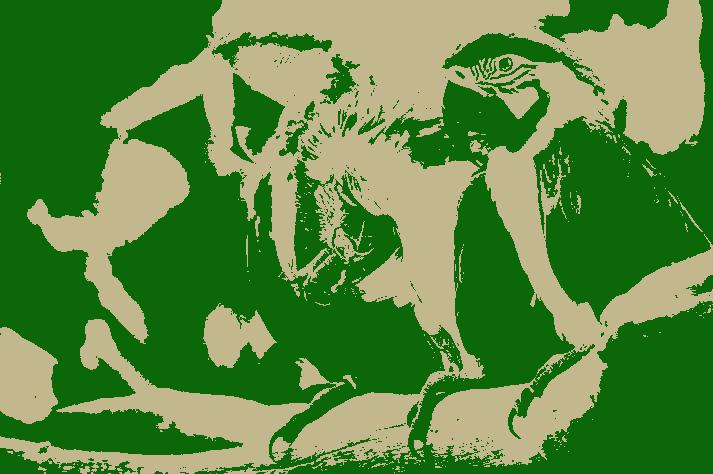

In [16]:
imsave('median.jpg', median_img)
Image(filename='median.jpg')

Измерьте качество получившейся сегментации с помощью метрики PSNR для обоих изображений.

In [17]:
print("Mean: ",psnr(img, mean_img), "Median: ",psnr(img, median_img))

Mean:  12.080178932671712 Median:  11.65362441781931


Найдите минимальное количество кластеров, при котором значение PSNR выше 20 (можно рассмотреть не более 20 кластеров, но не забудьте рассмотреть оба способа заполнения пикселей одного кластера).

In [33]:
for n in range(1, 20):
    kmeans = KMeans(n_clusters=n, init='k-means++', random_state=3, n_jobs=-1)
    X['cluster'] = kmeans.fit_predict(X)
    set_new_colors = lambda a: np.reshape(list(map(lambda c: a[c], X['cluster'])), (w, h, -1))
    mean_colors = X.groupby('cluster').mean().values
    median_colors = X.groupby('cluster').median().values
    mean_img = set_new_colors(mean_colors)
    median_img = set_new_colors(median_colors)
    mean_psnr = psnr(img, mean_img)
    median_psnr = psnr(img, median_img)
    print("Mean ", n, " : ", mean_psnr)
    print("Median ", n, " : ", median_psnr)
    if (mean_psnr > 20 or median_psnr > 20):
        if (mean_psnr > 20):
            print("MEAN ", n)
            break
        else:
            print("MEDIAN ", n)
            break

Mean  1  :  9.818835544771293
Median  1  :  9.427840460507397
Mean  2  :  12.080181092982404
Median  2  :  11.653834879655246
Mean  3  :  13.049773023215938
Median  3  :  12.57340960403241
Mean  4  :  14.213562847003473
Median  4  :  13.681784299835531
Mean  5  :  15.242444963880173
Median  5  :  14.742199955001723
Mean  6  :  15.946223782218228
Median  6  :  15.477606245968127
Mean  7  :  16.71684106055157
Median  7  :  16.16420832194258
Mean  8  :  17.594330006681943
Median  8  :  17.00838724643613
Mean  9  :  18.430814220629436
Median  9  :  18.01916636396539
Mean  10  :  18.81057471067969
Median  10  :  18.36747454543287
Mean  11  :  19.226736739126103
Median  11  :  18.841803546926776
Mean  12  :  19.52177556210734
Median  12  :  19.195514114299947
Mean  13  :  19.838122462924503
Median  13  :  19.487108608577778
Mean  14  :  20.13788661521763
Median  14  :  19.861168729851734
MEAN  14
